In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")
# 라이브러리 & DB 연결
DB_USER = "root"
DB_PASSWORD = "fls0413!"
DB_HOST = "127.0.0.1"   # localhost ❌
DB_PORT = 3306
DB_NAME = "core5_ems"

engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    echo=False
)

In [7]:
pd.read_sql("SHOW TABLES;", engine)

,Tables_in_core5_ems
0,core5_control_result
1,core5_ems_ess_iot
2,ems_ess_core4
3,pacemaker_iot


DB 테이블 확인

In [12]:
core4 = pd.read_sql(
    "SELECT * FROM ems_ess_core4",
    engine,
    parse_dates=["timestamp"]
).sort_values("timestamp")

pm = pd.read_sql(
    "SELECT * FROM pacemaker_iot",
    engine
)

Core 4 (EMS–ESS) 데이터 로드

In [ ]:
N = min(len(core4), len(pm))

core4_seq = core4.iloc[:N].reset_index(drop=True)
pm_seq = pm.iloc[:N].reset_index(drop=True)
pm_seq = pm_seq.drop(columns=["timestamp"], errors="ignore")
core5 = pd.concat([core4_seq, pm_seq], axis=1)


core5.to_sql(
    name="core5_ems_ess_iot",
    con=engine,
    if_exists="replace",
    index=False
)

core5.shape

(8760, 33)

의료 IoT (페이스메이커) 데이터 로드

In [17]:
pm = pd.read_sql(
    "SELECT * FROM pacemaker_iot",
    engine
)

pm.head(), pm.shape

(     timestamp  episode_id  step  patient_id  age  sex  weight_kg diagnosis  \
 0  000000_0000           0     0           0   88    1  61.657439        AF   
 1  000000_0001           0     1           0   88    1  61.657439        AF   
 2  000000_0002           0     2           0   88    1  61.657439        AF   
 3  000000_0003           0     3           0   88    1  61.657439        AF   
 4  000000_0004           0     4           0   88    1  61.657439        AF   
 
    baseline_hr       egfr  ...  prev_pacing_rate  action  new_pacing_rate  \
 0    93.189022  79.192128  ...                76       0               76   
 1    93.189022  79.192128  ...                76       0               76   
 2    93.189022  79.192128  ...                76       1               81   
 3    93.189022  79.192128  ...                81       0               81   
 4    93.189022  79.192128  ...                81       0               81   
 
      next_hr    next_sbp   next_dbp  next_spo2 

Core 5 통합 테이블 로드

In [18]:
core5 = pd.read_sql(
    "SELECT * FROM core5_ems_ess_iot",
    engine,
    parse_dates=["timestamp"]
).set_index("timestamp")

core5.head(), core5.shape

(                    household_id  consumption  Season  temperature  humidity  \
 timestamp                                                                      
 2013-03-01 00:00:00    MAC000001        6.219  Spring         2.58      0.84   
 2013-03-01 01:00:00    MAC000001        5.510  Spring         2.97      0.84   
 2013-03-01 02:00:00    MAC000001        8.393  Spring         2.99      0.87   
 2013-03-01 03:00:00    MAC000001        6.876  Spring         3.03      0.87   
 2013-03-01 04:00:00    MAC000001        4.000  Spring         3.07      0.91   
 
                      windSpeed  episode_id  step  patient_id  age  ...  \
 timestamp                                                          ...   
 2013-03-01 00:00:00       3.94           0     0           0   88  ...   
 2013-03-01 01:00:00       3.35           0     1           0   88  ...   
 2013-03-01 02:00:00       2.70           0     2           0   88  ...   
 2013-03-01 03:00:00       2.51           0     3       

스마트그리드 ↔ 의료 IoT 대응 구조

| 스마트그리드 | 의료 IoT |
|---|---|
| Load (kW) | Heart Rate |
| ESS SOC | Physiological Reserve |
| Ramp | HR Change |
| Forecast Signal | Next HR |
| EMS Rule | Intervention Logic |

Reactive / Proactive / Context-aware 신호 정의

In [19]:
df = core5.copy()

# 상태(state)
df["state"] = df["current_hr"]

# Reactive: 현재 상태 기준
df["signal_reactive"] = df["state"]

# Proactive: 다음 상태 정보
df["signal_proactive"] = df["next_hr"]

# Context-aware: 정보 밀도 기반 proxy
df["signal_context"] = (
    df["current_hr"]
    + 0.5 * (df["next_hr"] - df["current_hr"])
)

df[["signal_reactive", "signal_proactive", "signal_context"]].head()

,signal_reactive,signal_proactive,signal_context
timestamp,,,
2013-03-01 00:00:00,90.841650,87.756099,89.298874
2013-03-01 01:00:00,87.756099,82.980294,85.368196
2013-03-01 02:00:00,82.980294,82.098661,82.539477
2013-03-01 03:00:00,82.098661,80.554684,81.326672
2013-03-01 04:00:00,80.554684,85.305535,82.930109


공통 EMS 규칙 적용

In [20]:
threshold = df["state"].quantile(0.95)
alpha = 0.10

def ems_control(signal):
    return np.where(
        signal > threshold,
        alpha * (signal - threshold),
        0.0
    )

df["inter_reactive"] = ems_control(df["signal_reactive"])
df["inter_proactive"] = ems_control(df["signal_proactive"])
df["inter_context"] = ems_control(df["signal_context"])

제어 후 상태 계산

In [21]:
df["after_reactive"] = df["state"] - df["inter_reactive"]
df["after_proactive"] = df["state"] - df["inter_proactive"]
df["after_context"] = df["state"] - df["inter_context"]

df[[
    "state",
    "after_reactive",
    "after_proactive",
    "after_context"
]].head()

,state,after_reactive,after_proactive,after_context
timestamp,,,,
2013-03-01 00:00:00,90.841650,90.841650,90.841650,90.841650
2013-03-01 01:00:00,87.756099,87.756099,87.756099,87.756099
2013-03-01 02:00:00,82.980294,82.980294,82.980294,82.980294
2013-03-01 03:00:00,82.098661,82.098661,82.098661,82.098661
2013-03-01 04:00:00,80.554684,80.554684,80.554684,80.554684


HR Ramp 비교

In [22]:
def ramp(x):
    return x.diff().abs()

ramp_df = pd.DataFrame({
    "Reactive": ramp(df["after_reactive"]),
    "Proactive": ramp(df["after_proactive"]),
    "Context-aware": ramp(df["after_context"])
})

ramp_df.describe()

,Reactive,Proactive,Context-aware
count,8759.000000,8759.000000,8759.000000
mean,3.921474,3.942309,3.933023
std,4.861334,4.886359,4.876979
min,0.000272,0.000272,0.000272
25%,1.328184,1.330255,1.326242
50%,2.780286,2.794476,2.792560
75%,4.886156,4.914911,4.899522
max,58.787470,58.807364,58.757127


SpO₂ 위험 이벤트 비교

In [23]:
spo2_risk = pd.DataFrame({
    "Reactive": (df["next_spo2"] < 90).astype(int),
    "Proactive": (df["next_spo2"] < 90).astype(int),
    "Context-aware": (df["next_spo2"] < 90).astype(int)
})

spo2_risk.sum()

Reactive         242
Proactive        242
Context-aware    242
dtype: int64

시각화 (해석용)

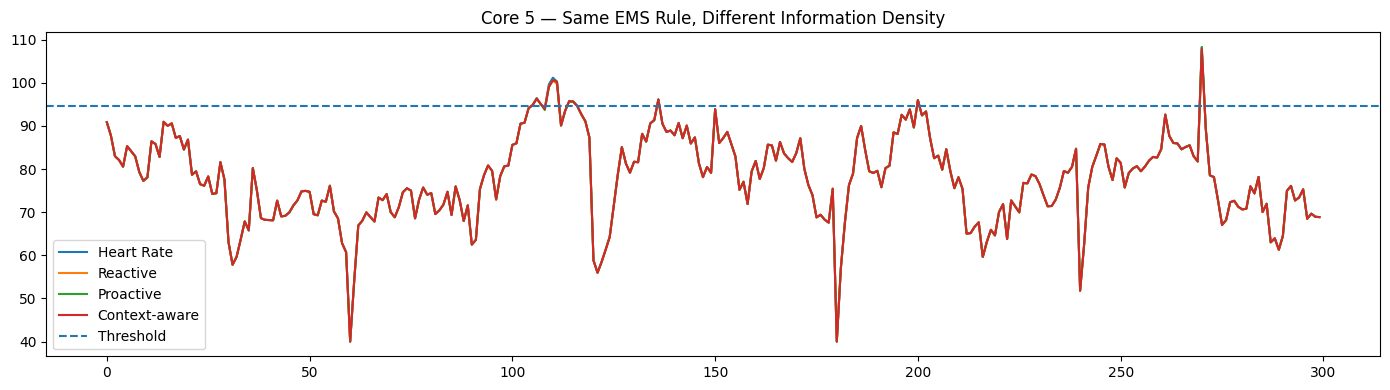

In [24]:
n = 300

plt.figure(figsize=(14,4))
plt.plot(df["state"].values[:n], label="Heart Rate")
plt.plot(df["after_reactive"].values[:n], label="Reactive")
plt.plot(df["after_proactive"].values[:n], label="Proactive")
plt.plot(df["after_context"].values[:n], label="Context-aware")
plt.axhline(threshold, linestyle="--", label="Threshold")
plt.legend()
plt.title("Core 5 — Same EMS Rule, Different Information Density")
plt.tight_layout()
plt.show()

### Conclusion

동일한 EMS 제어 규칙을 사용하더라도,  
의료 IoT 환경에서는 상태 정보의 밀도와 맥락 차이로 인해  
제어 개입의 시점과 효과가 구조적으로 달라진다.

이는 스마트그리드가 단일 산업 문제가 아니라,  
**산업 인프라 전반에 적용 가능한 제어 구조임**을 보여준다.